In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

import pandas as pd
import tensorflow as tf
import keras as keras
from keras import layers

from skimage.util import random_noise
from skimage.filters import threshold_multiotsu

Mounted at /content/drive


In [ ]:
from scipy.signal import convolve2d

In [ ]:
# function to add Gaussian noise to image
def addNoise(img, noiseFactor):
  h = len(img)
  w = len(img[0])
  noise_img = 255*random_noise(img, mode='s&p',amount=noiseFactor)
  return noise_img

def preprocess(img, noise=False, noiseFactor=None):
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  r,g,b = cv2.split(rgb_img)
  for i in range(len(g)):
    for j in range(len(g[i])):
      g[i][j] = 0

  rgb = np.dstack((b,g,r))

  hsv_img = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)
  h,s,v = cv2.split(hsv_img)
  hsv_split = np.concatenate((h,s,v),axis=1)

  thresholds = threshold_multiotsu(v, classes=3)
  if noise: v = addNoise(v, noiseFactor)

  # Using the threshold values, we generate the three regions.
  regions = np.digitize(v, bins=thresholds)

  return regions

def cutImageUp(img, w, h):
  rowRange = range(0, len(img)//w * w, w)
  colRange = range(0, len(img[0])//h * h, h)
  cutup = np.zeros(((len(rowRange)) * (len(colRange)), w, h, 1))
  index = 0
  for (ri, i) in enumerate(rowRange):
    for (ci, j) in enumerate(colRange):
      cutup[index] = np.reshape(img[i : (i + w), j : (j + h)], (w, h, 1))
      index = index + 1
  return cutup

def stitchTogether(cutImg, w, h):
  dim = cutImg[0].shape
  w_i, h_i = dim[0], dim[1]
  n = len(cutImg)

  rangeW = w // w_i
  rangeH = h // h_i

  img_lst = []

  cnt = 0
  for j in range(0, rangeH):
    lst = []
    for i in range(0, rangeW):
      if cnt >= n:
         return cv2.vconcat(img_lst)
      lst.append(cutImg[cnt])
      cnt += 1
    img_lst.append(cv2.hconcat(lst))



  return cv2.vconcat(img_lst)

In [ ]:
nodefect_autoencoder = keras.models.load_model('/content/drive/MyDrive/ENEE 439D Final Project/Aerospace PCB Our Pics/nodefectReconstruct')

# DeepPCB Dataset Analysis

In [ ]:
def classify_regular_pcb(file_path, preprocessBool=True, invert=False):
  img = cv2.imread(file_path)
  if not preprocessBool: 
    img[img > 255/2] = 255.
    img[img < 255/2] = 0.
    if invert: img = (255 - img)/255
    if not invert: img = img/255
    r,g,b = cv2.split(img)
    img = r
    
  if preprocessBool: 
    img = preprocess(img)
    img[img > 0.5] = 1.
    img[img < 0.5] = 0.
  #cv2_imshow(img*255)
  
  cutup = cutImageUp(img, 80, 80)
  prediction = nodefect_autoencoder.predict(cutup, verbose=0)
  prediction = np.reshape(prediction, np.shape(prediction)[:-1])
  h, w = img.shape

  # scale up images
  prediction = [img for img in prediction]
  cutup = [img for img in cutup]

  pred_full = stitchTogether(prediction, w, h)
  #cv2_imshow(pred_full*255)
 
  original_img = stitchTogether(cutup, w, h)
  difference = np.abs(np.subtract(original_img, pred_full))
  difference[difference < 0.] = 0.
  sum_kernel = np.tile(1/9., (3, 3))
  difference = convolve2d(difference, sum_kernel, 'same')
  difference[difference < 0.5] = 0
  difference[difference >= 0.5] = 1
  #cv2_imshow(difference*255)
  return difference
  

In [ ]:
def defect_segmentation_mask(template, test, defects=None,
                             preprocessBool = False, 
                             invert = False, 
                             bb = False):
  template = cv2.imread(template)
  img = template
  if not preprocessBool: 
    img[img > 255/2] = 255.
    img[img < 255/2] = 0.
    if invert: img = (255 - img)/255
    if not invert: img = img/255
    r,g,b = cv2.split(img)
    img = r
    
  if preprocessBool: 
    img = preprocess(img)
    img[img > 0.5] = 1.
    img[img < 0.5] = 0.

  template = img

  test = cv2.imread(test)
  img = test
  if not preprocessBool: 
    img[img > 255/2] = 255.
    img[img < 255/2] = 0.
    if invert: img = (255 - img)/255
    if not invert: img = img/255
    r,g,b = cv2.split(img)
    img = r
    
  if preprocessBool: 
    img = preprocess(img)
    img[img > 0.5] = 1.
    img[img < 0.5] = 0.
    
  test = img
  difference = np.abs(np.subtract(test, template))

  if bb:
    for i in range(len(difference)):
      for j in range(len(difference[0])):
        valid = False
        for defect in defects:
          if defect[-1] in [1] and defect[1] <= i and i <= defect[3] and defect[0] <= j and j <= defect[2]:
            valid = True
        if not valid: difference[i, j] = 0
  
  difference[difference < 0.] = 0.
  sum_kernel = np.tile(1/9., (3, 3))
  difference = convolve2d(difference, sum_kernel, 'same')
  difference[difference < 0.5] = 0
  #cv2_imshow(difference*255)
  return difference

In [ ]:
defect_segmentation_mask("/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Template/901000682_temp.jpg",
                         "/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Test/901000682_test.jpg")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
defect_segmentation_mask("/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Template/000410041_temp.jpg",
                         "/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Test/000410041_test.jpg")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
classify_regular_pcb("/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Test/901000682_test.jpg", preprocessBool=False)

1/1 [==============================] - 0s 31ms/step


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
classify_regular_pcb("/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Test/901000682_test.jpg", preprocessBool=False)

In [ ]:
def quantify_performance_deeppcb():
  tempPath = "/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Template/"
  testPath = "/content/drive/MyDrive/ENEE 439D Final Project/Deep PCB Data/Test/"
  

  precisions = np.asarray([])
  recalls = np.asarray([])

  p = 0

  for i in os.listdir(tempPath):
    print(i)
    temp_img_path = tempPath + i
    test_img_path = testPath + i.split("_")[0] + "_test.jpg"

    difference = classify_regular_pcb(test_img_path, preprocessBool=False, invert=False)

    defect_mask = defect_segmentation_mask(temp_img_path,
                                           test_img_path)

    cv2_imshow(difference*255)
    cv2_imshow(defect_mask*255)


    false_positive = np.subtract(difference, defect_mask) 
    false_positive[false_positive < 0] = 0

    true_positive = np.subtract(difference, false_positive)

    cv2_imshow(false_positive*255)
    cv2_imshow(true_positive*255)

    precision = np.sum(true_positive) / np.sum(false_positive + true_positive)

    if  np.sum(false_positive + true_positive) == 0.0:
      precision = 0.0

    print(precision)


    false_negative = np.subtract(defect_mask, difference)
    false_negative[false_negative < 0] = 0

    cv2_imshow(false_negative*255)
    
    recall = np.sum(true_positive) / np.sum(false_negative + true_positive)
    if  np.sum(false_negative + true_positive) == 0.0:
      recall = 0.0
    print(recall)

    #if precision+recall == 0:
     # cv2_imshow(difference*255)
     # cv2_imshow(defect_mask*255)

    recalls = np.append(recalls, recall)
    precisions = np.append(precisions, precision)

    p += 1
    if p == 2:
      break

  return recalls, precisions
  print(np.average(precisions))
  print(np.average(recalls))


121001612_temp.jpg


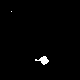

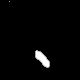

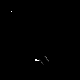

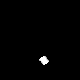

0.8333333333333335


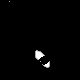

0.4040404040404041
121000220_temp.jpg


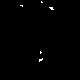

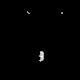

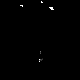

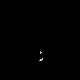

0.28148148148148155


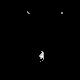

0.23602484472049695


(array([0.4040404 , 0.23602484]), array([0.83333333, 0.28148148]))

In [ ]:
quantify_performance_deeppcb()

In [ ]:
recall, precisions = quantify_performance_deeppcb()

<ipython-input-20-a68220a45b7f>:32: RuntimeWarning: invalid value encountered in double_scalars
  precision = np.sum(true_positive) / np.sum(false_positive + true_positive)
<ipython-input-20-a68220a45b7f>:45: RuntimeWarning: invalid value encountered in double_scalars
  recall = np.sum(true_positive) / np.sum(false_negative + true_positive)


In [ ]:
print(np.mean(precisions))
print(np.mean(recall))
print(len(precisions))
print(len(recall))

0.5630756306371744
0.5171856370808613
3060
3060


In [ ]:
print(np.mean(precisions))
print(np.mean(recall))
print(len(precisions))
print(len(recall))

0.6614983482731479
0.462506603314257
3060
3060
